In [56]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

In [57]:
df = pd.read_csv('BBC_News_Train.csv')

In [58]:
df.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


A quick look at the datatypes and counts indicate that there are zero null values, so no imputation will be required here.

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


Assessing the counts of each category of the target variable indicates relatively balanced data. Paring of data to achieve balance will not be utilized here.

<AxesSubplot: >

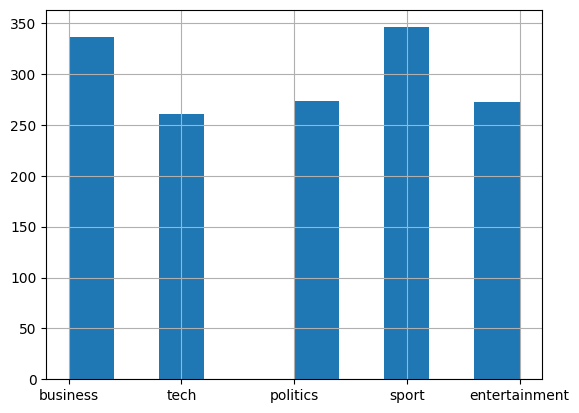

In [60]:
df.Category.hist()

It can be seen that the average word count is 414, with the word counts following a somewhat normal distribution with a fat right tail. Since there do not appear to be noticable sub-groupings based on word count, it will not be used as an attribute in generating models. 

Mean word count:  414.04295302013423


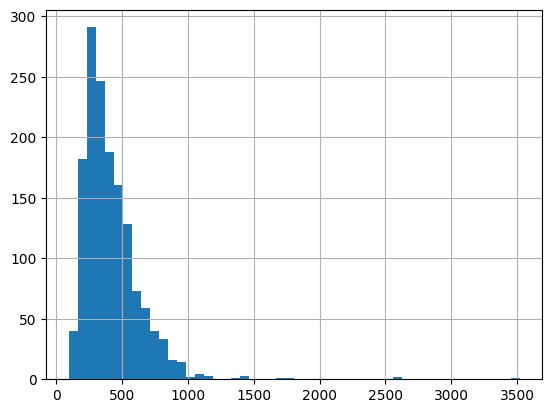

In [61]:
word_counts = df.Text.str.split(' ').str.len()
word_counts.hist(bins=50)
print('Mean word count: ', word_counts.mean())

The text is vectorized to allow for processing by the models. An L1 loss function is used, as this should perform better on the more sparse natures of the vectorized data than the default L2 loss function. Both unigrams and bigrams (single words as well as two-word phrases) will be assessed. Stop words are not considered here. Additionally, the 5% of most common words will be filtered out. The 1% of least common words will also be filtered out to help prevent overfitting. Sublinear term frequency will be enabled as word counts follow a somewhat normal distribution as demonstrated above, and enabling this normalized these word counts by using their logs. 

In [62]:
vect = TfidfVectorizer(sublinear_tf=True, norm='l1', min_df=0.01, max_df=0.95, ngram_range=(1,2), stop_words='english')
vectX = vect.fit_transform(df.Text)

vectX = vectX.toarray()
df_vect = pd.DataFrame(vectX, columns=vect.get_feature_names_out())
df_vect['Category'] = df.Category
df_vect.insert(0, 'ArticleId', df.ArticleId, True)
#df_vect.index = df.ArticleId

print(df_vect.shape)
df_vect.head()

(1490, 3224)


,ArticleId,000,000 jobs,000 people,000 year,10,10 000,10 years,100,100 000,...,years ago,yen,yes,york,young,young people,younger,yukos,zealand,Category
0,1833,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.008698,0.0,0.0,0.000000,0.0,0.0,business
1,154,0.000000,0.0,0.000000,0.0,0.005178,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,business
2,1101,0.003740,0.0,0.006639,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.005999,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,business
3,1976,0.002956,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.004742,0.0,0.0,0.000000,0.0,0.0,0.010085,0.0,0.0,tech
4,917,0.000000,0.0,0.000000,0.0,0.004602,0.0,0.0,0.0,0.0,...,0.006944,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,business


In [63]:
labels = df.Category.unique()
labels

array(['business', 'tech', 'politics', 'sport', 'entertainment'],
      dtype=object)

In [64]:
vectX

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00373962, 0.        , 0.00663895, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00595473, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [65]:
nmf_model = NMF(n_components=5, init='random', random_state=10)
# Consider changing loss function
W = nmf_model.fit_transform(vectX)
H = nmf_model.components_

A function built to determine the top n words per category. The categories as of now are unlabled, but it can be easily assumed which grouping belongs to which category. 

In [66]:
def max_impact_words(mat, word_names, num_words=5):
    for cat in mat:
        locs = cat.argsort()[-num_words:][::-1]
        print(word_names[locs])

words = vect.get_feature_names_out()     
max_impact_words(H, word_names=words)

['game' 'win' 'match' 'england' 'cup']
['film' 'best' 'awards' 'actor' 'award']
['people' 'users' 'software' 'use' 'microsoft']
['mr' 'labour' 'election' 'party' 'blair']
['said' 'market' 'growth' 'year' 'company']


In [70]:
Wpred = nmf_model.inverse_transform(W)
Wpred

array([[1.83911948e-03, 3.47941742e-04, 3.31571391e-04, ...,
        7.37760341e-05, 8.01336502e-04, 5.48210191e-05],
       [2.48914698e-03, 6.35036681e-04, 4.63426780e-04, ...,
        0.00000000e+00, 1.46671107e-03, 6.36860889e-05],
       [1.78401884e-03, 3.08309123e-04, 3.35301602e-04, ...,
        1.00145786e-04, 7.09846281e-04, 1.31033190e-04],
       ...,
       [2.41593496e-03, 6.04212029e-04, 4.45366875e-04, ...,
        9.68317512e-06, 1.39551698e-03, 9.57704225e-05],
       [2.27812615e-03, 1.18525309e-04, 5.32024897e-04, ...,
        1.81306809e-04, 2.73751719e-04, 1.60340163e-05],
       [2.49585135e-03, 0.00000000e+00, 6.33211744e-04, ...,
        2.53157016e-04, 0.00000000e+00, 0.00000000e+00]])

In [71]:
print(Wpred.shape, H.shape)

(1490, 3222) (5, 3222)


In [72]:
W

array([[0.00011631, 0.00353247, 0.00316117, 0.00894017, 0.02217619],
       [0.        , 0.        , 0.        , 0.        , 0.04154405],
       [0.00369197, 0.00117713, 0.0058866 , 0.00875573, 0.01959552],
       ...,
       [0.00143299, 0.00135507, 0.        , 0.        , 0.0395275 ],
       [0.        , 0.00324897, 0.0355502 , 0.        , 0.00775392],
       [0.        , 0.        , 0.05127058, 0.        , 0.        ]])

In [125]:
ordered_labels = {0:'sport', 1:'entertainment', 2:'tech', 3:'politics', 4:'business'}

In [75]:
max_index = H.argmax(axis=0)
max_index

array([4, 4, 2, ..., 3, 4, 0], dtype=int64)

Takes a vectorized dataframe of ArticleId and word frequencies and predicts a category.

In [122]:
def nmf_predict(dataframe):
    IDs = dataframe.ArticleId
    df_calc = dataframe.iloc[:, 1:]
    calcs = np.dot(H, np.transpose(df_calc))
    best = calcs.argmax(axis=0)
    data = {'ArticleId': IDs, 'Category': best}
    return pd.DataFrame(data)
    
preds = nmf_predict(df_vect.iloc[:, :-1])
preds

,ArticleId,Category
0,1833,4
1,154,4
2,1101,4
3,1976,2
4,917,4
...,...,...
1485,857,0
1486,325,1
1487,1590,4
1488,1587,2


In [121]:
z = df_vect.iloc[:, :-1]
#z.iloc[:, 1:]

In [129]:
preds = preds.replace({'Category':ordered_labels})

In [133]:
vals = preds.Category == df.Category
vals.sum() / vals.count()

0.9140939597315436